### Faithfulness

  0%|          | 0/30 [00:00<?, ?it/s]

ArticularyWordRecognition 0.9933333333333333
AtrialFibrillation 0.5333333333333333
BasicMotions 1.0
CharacterTrajectories 0.9818941504178273
Cricket 0.9861111111111112
DuckDuckGeese 0.38
ERing 0.9629629629629629
EigenWorms 0.5877862595419847
Epilepsy 0.9927536231884058
EthanolConcentration 0.3155893536121673
FaceDetection 0.6555051078320091
FingerMovements 0.57
HandMovementDirection 0.5135135135135135
Handwriting 0.33176470588235296
Heartbeat 0.7365853658536585
InsectWingbeat 0.50152
JapaneseVowels 0.9594594594594594
LSST 0.6362530413625304
Libras 0.8888888888888888
MotorImagery 0.64
NATOPS 0.8833333333333333
PEMS-SF 0.8497109826589595


/home/weny2/anaconda3/envs/ts/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/weny2/anaconda3/envs/ts/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


PenDigits 0.9705546026300743
PhonemeSpectra 0.2573814494482553
RacketSports 0.8947368421052632
SelfRegulationSCP1 0.856655290102389
SelfRegulationSCP2 0.5333333333333333
SpokenArabicDigits 0.9931787175989086
StandWalkJump 0.5333333333333333
UWaveGestureLibrary 0.9125


/tmp/ipykernel_23742/3733735076.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(faithfulness_all.keys(), fontsize=16)


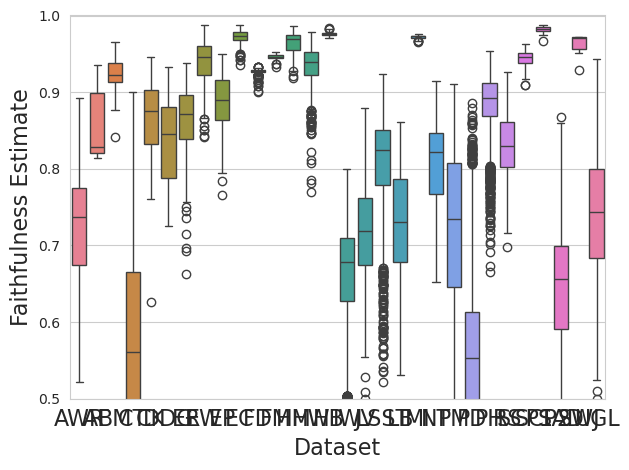

In [1]:
import pickle
import numpy as np
from scipy.special import softmax
import copy
import os
import glob
from tqdm.auto import tqdm

root = "."
datasets = sorted([x for x in os.listdir(root + "/checkpoints/SBM") if os.path.isdir(os.path.join(root + "/checkpoints/SBM", x))])
datasets

faithfulness_all = {}

def compute_faithfulness(dataset):
    pkl_file = glob.glob(f'{root}/checkpoints/SBM/{dataset}/*/test_results.pkl')
    d = pickle.load(open(pkl_file[0], 'rb'))
    p = d['predicate']
    orignial_prob = softmax(d['pred'], axis=1)
    predicted_label = np.argmax(orignial_prob, axis=1)

    acc = (predicted_label == d['target']).mean()
    print(dataset, acc)

    faithfulness = []
    weight = []

    for i in range(p.shape[1]):
        pi = copy.deepcopy(p)
        pi[:, i] = 0
        new_logits = pi @ d['w'].T
        new_prob = softmax(new_logits, axis=1)

        prob_diff = orignial_prob - new_prob

        faith_list = []
        weight_list = []
        for sample_id in range(prob_diff.shape[0]):
            faith_list.append(prob_diff[sample_id, predicted_label[sample_id]])
            weight_list.append(d['w'][predicted_label[sample_id], i])

        faithfulness.append(np.array(faith_list))
        weight.append(np.array(weight_list))

    faithfulness = np.stack(faithfulness, axis=0)
    weight = np.stack(weight, axis=0)

    corr = []

    for i in range(faithfulness.shape[1]):
        corr.append(np.corrcoef(weight[:, i], faithfulness[:, i])[0, 1])

    return corr

dataset_map = {
    "ArticularyWordRecognition": "AWR",
    "AtrialFibrillation": "AF",
    "BasicMotions": "BM",
    "CharacterTrajectories": "CT",
    "Cricket": "CK",
    "DuckDuckGeese": "DDG",
    "ERing": "ER",
    "EigenWorms": "EW",
    "Epilepsy": "EP",
    "EthanolConcentration": "EC",
    "FaceDetection": "FD",
    "FingerMovements": "FM",
    "HandMovementDirection": "HM",
    "Handwriting": "HW",
    "Heartbeat": "HB",
    "InsectWingbeat": "IW",
    "JapaneseVowels": "JV",
    "LSST": "LSST",
    "Libras": "LB",
    "MotorImagery": "MI",
    "NATOPS": "NT",
    "PEMS-SF": "PM",
    "PenDigits": "PD",
    "PhonemeSpectra": "PH",
    "RacketSports": "RS",
    "SelfRegulationSCP1": "SCP1",
    "SelfRegulationSCP2": "SCP2",
    "SpokenArabicDigits": "SAD",
    "StandWalkJump": "SWJ",
    "UWaveGestureLibrary": "UGL"
}

for dataset in tqdm(datasets):
    try:
        corr = compute_faithfulness(dataset)
        faithfulness_all[dataset_map[dataset]] = corr
    except:
        print(f'{dataset} failed')


/tmp/ipykernel_23742/854599678.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(d1.keys(), fontsize=16)
/tmp/ipykernel_23742/854599678.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(d2.keys(), fontsize=16)


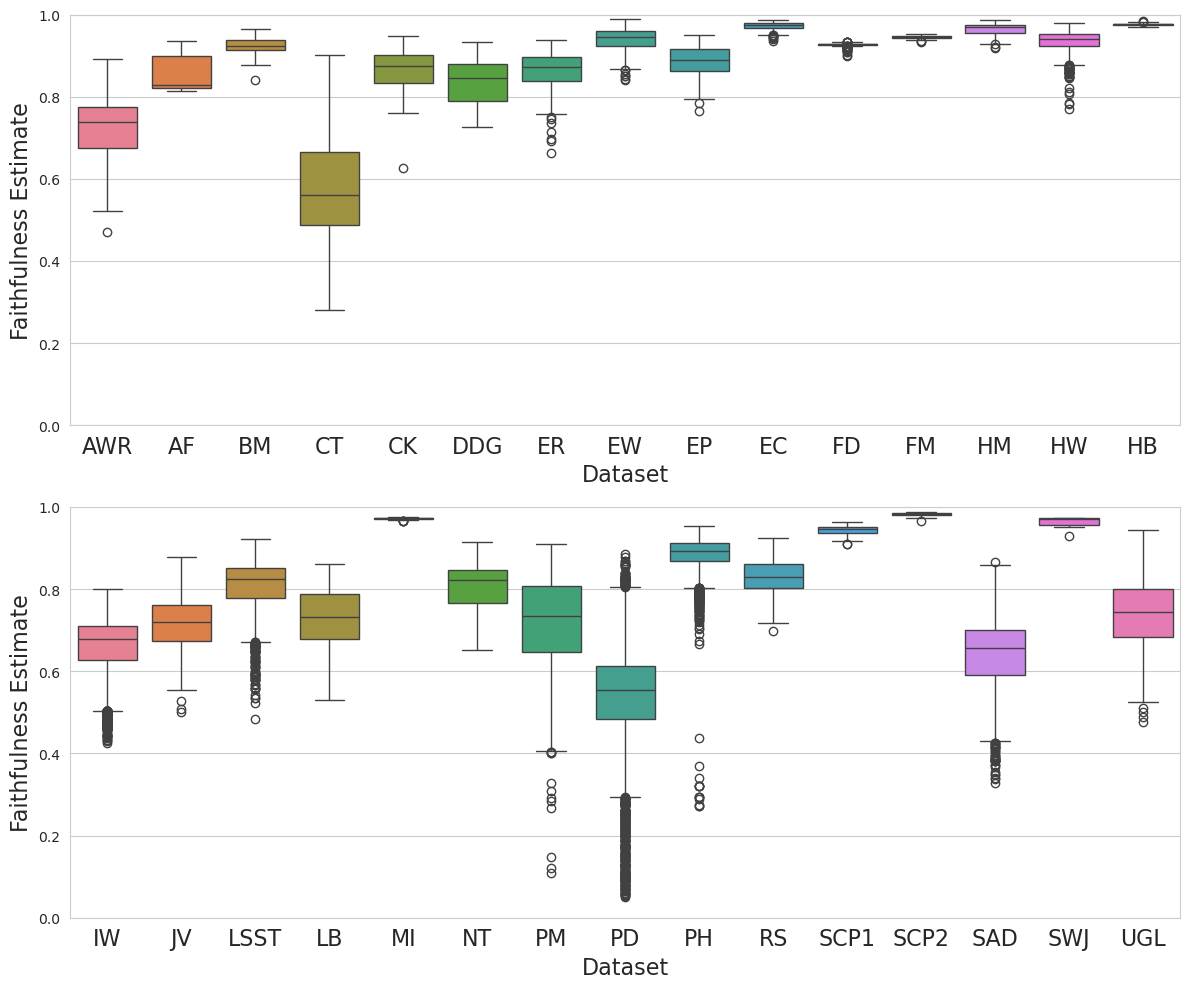

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

k1 = list(faithfulness_all.keys())[:15]
k2 = list(faithfulness_all.keys())[15:]

d1 = {k:faithfulness_all[k] for k in k1}
d2 = {k:faithfulness_all[k] for k in k2}

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(2, figsize=(12, 10))
    sns.boxplot(data=d1, ax=ax[0])
    ax[0].set_xticklabels(d1.keys(), fontsize=16)
    ax[0].set_xlabel('Dataset', fontsize=16)
    ax[0].set_ylabel('Faithfulness Estimate', fontsize=16)
    ax[0].set_ylim(0, 1)
    sns.boxplot(data=d2, ax=ax[1])
    ax[1].set_xticklabels(d2.keys(), fontsize=16)
    ax[1].set_xlabel('Dataset', fontsize=16)
    ax[1].set_ylabel('Faithfulness Estimate', fontsize=16)
    ax[1].set_ylim(0, 1)
    plt.tight_layout()
fig.savefig('../figures/faithfulness.pdf')

### Global Explanations

x (40, 100, 6)
pred (40, 4)
target (40,)
predicate (40, 360)
w (4, 360)
shapelets
eta
sbm_pred


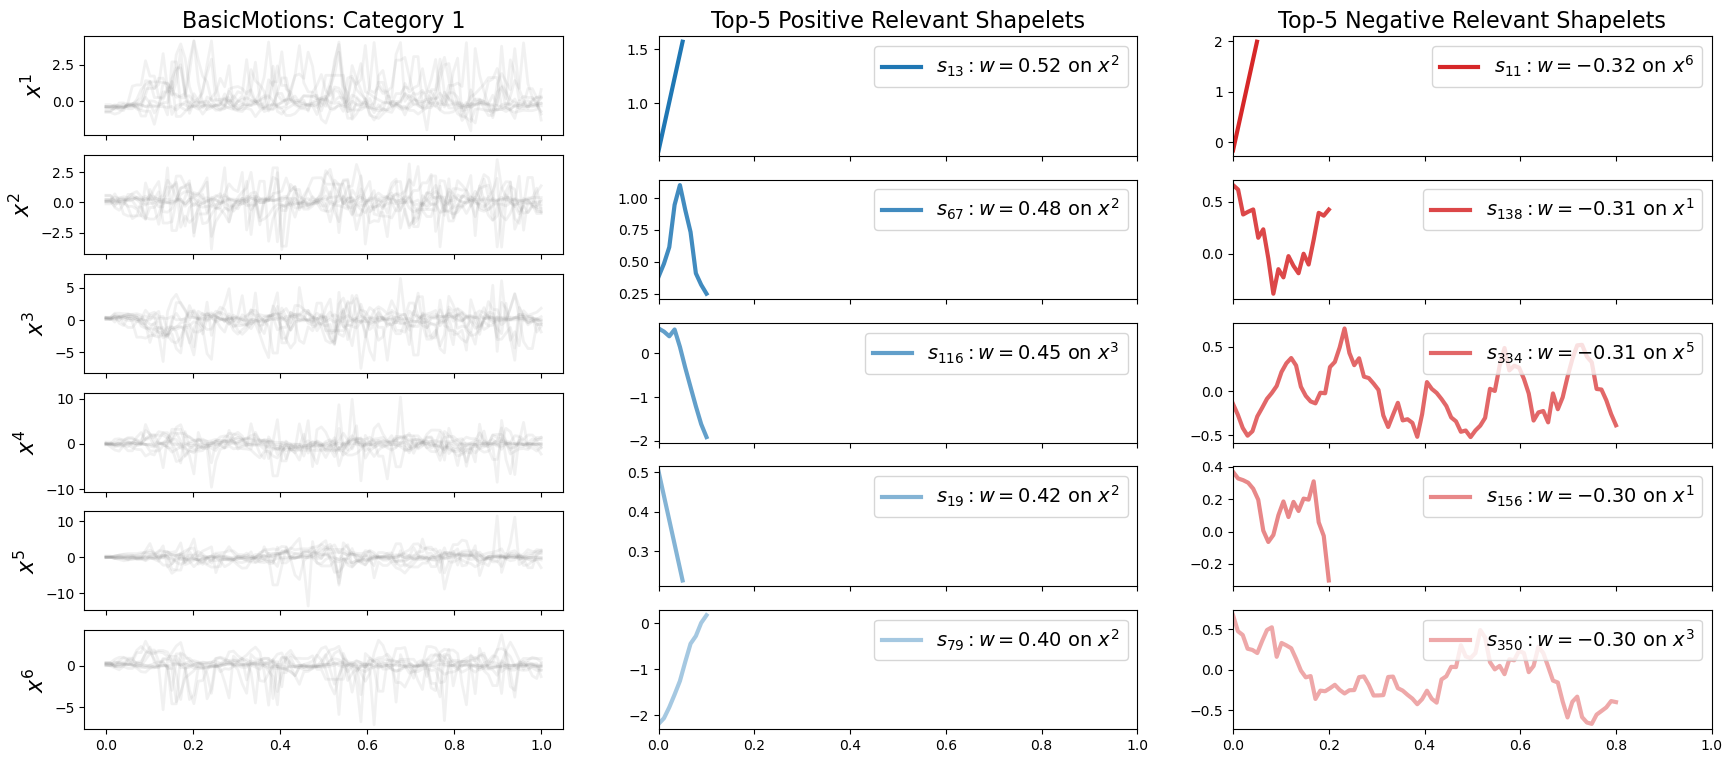

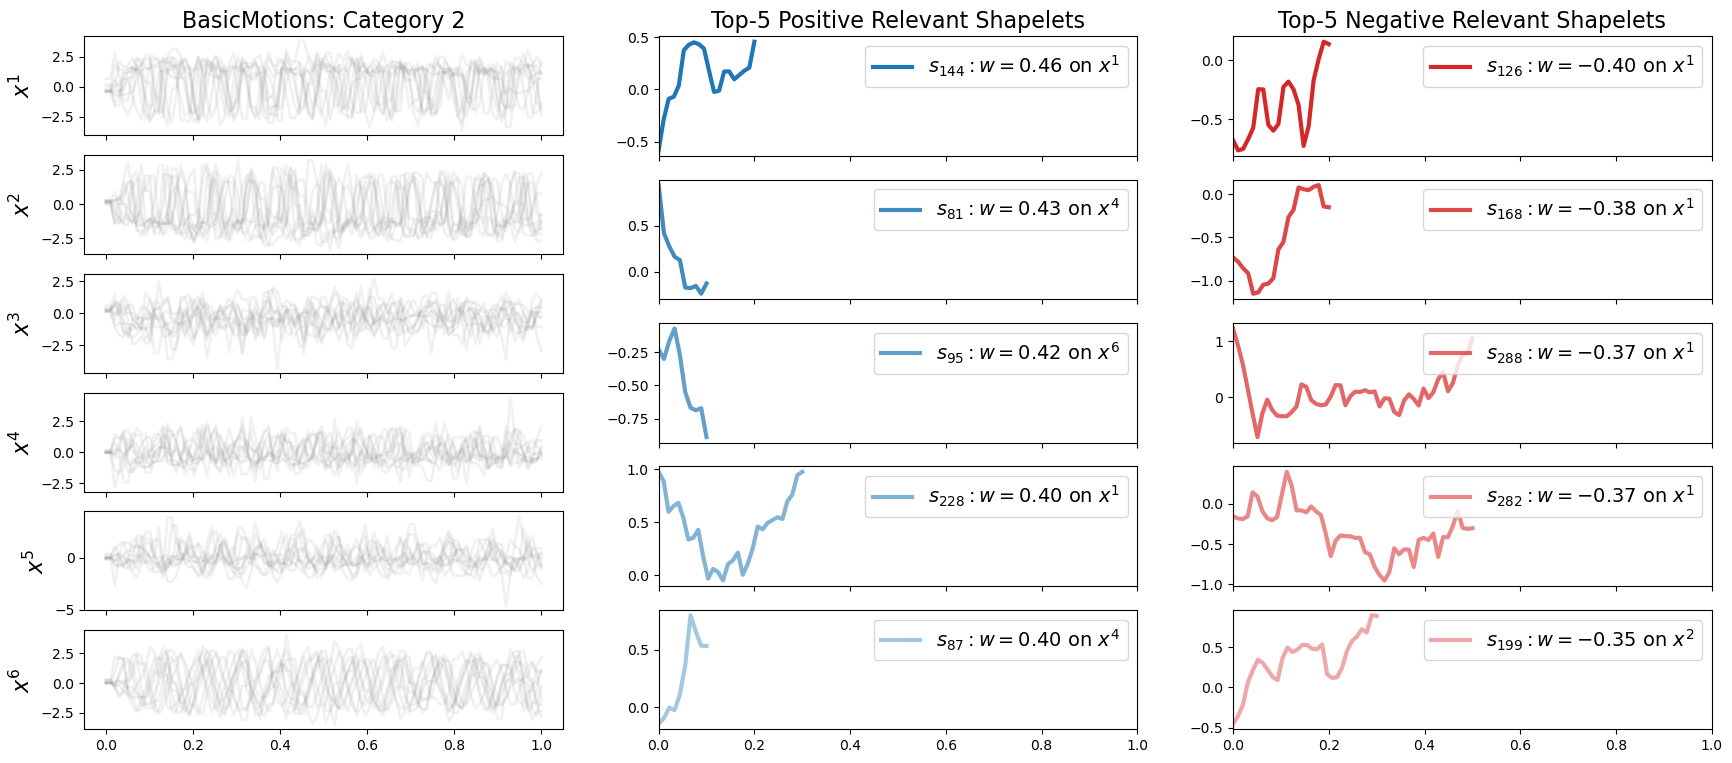

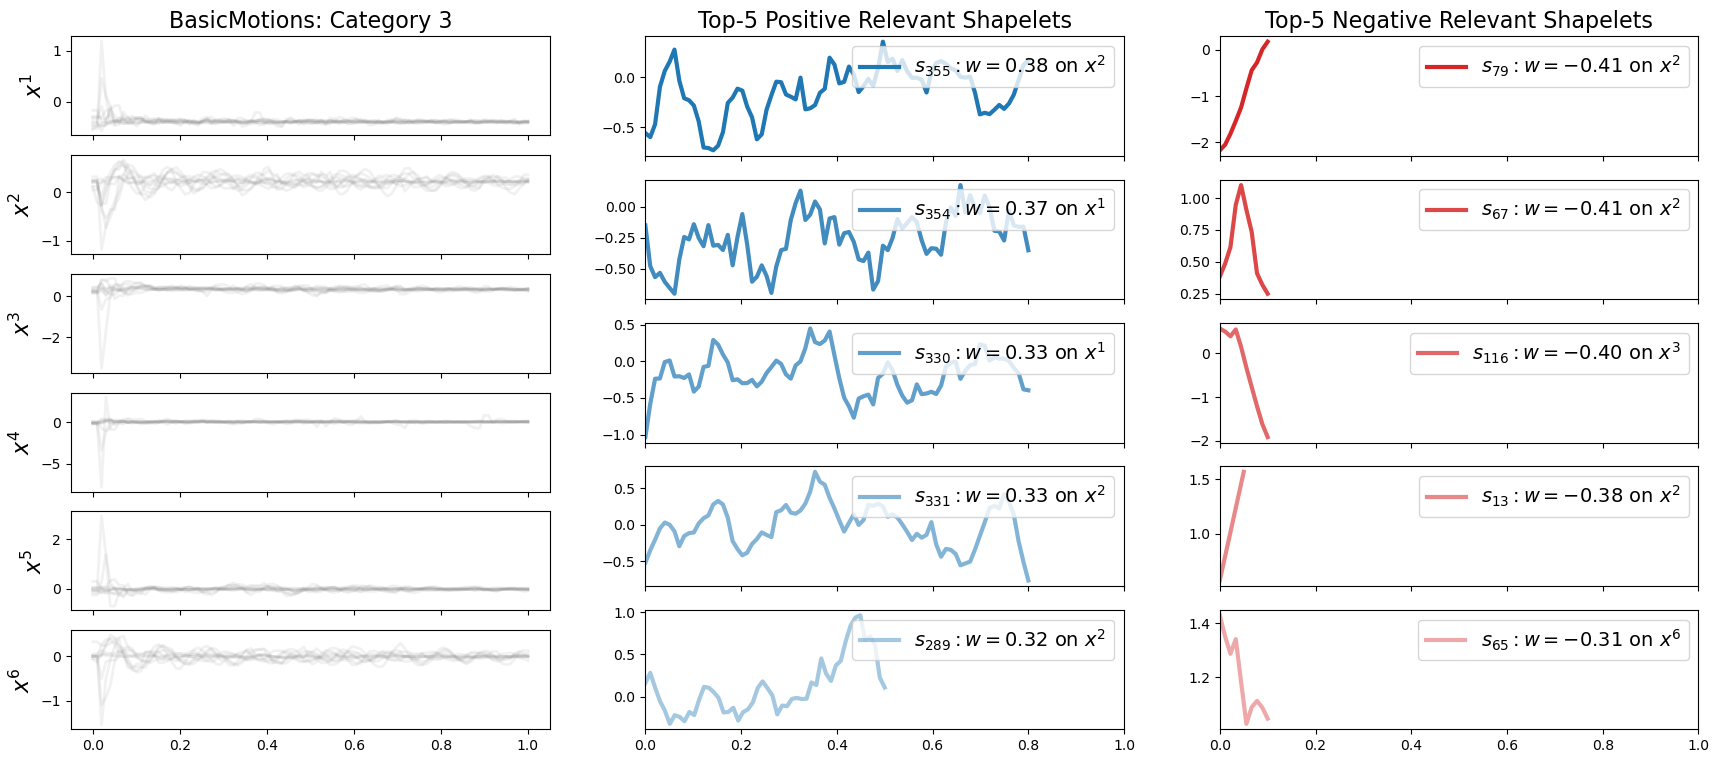

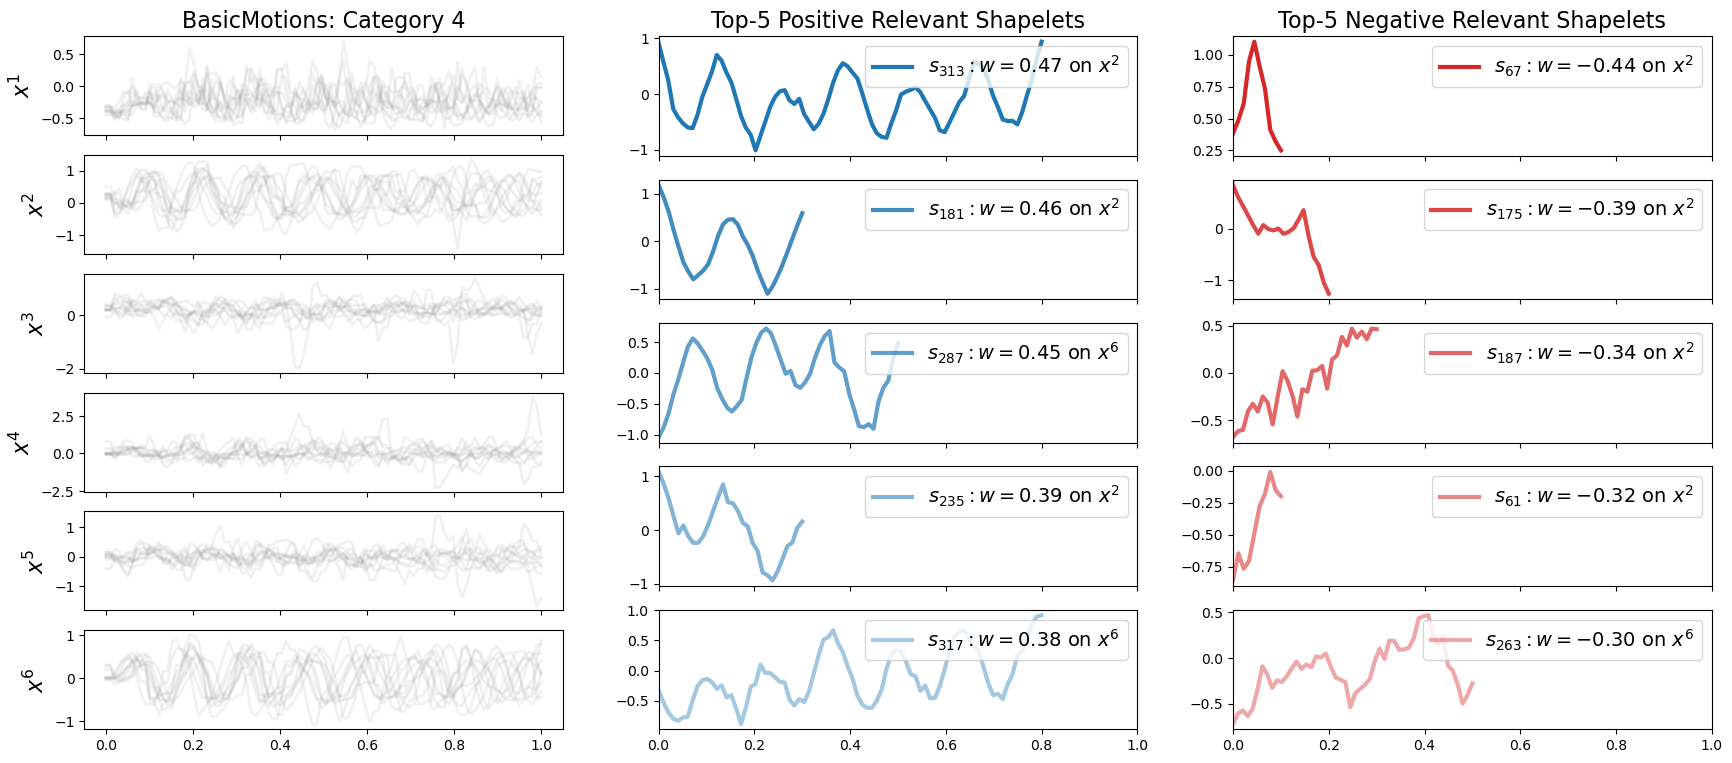

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def smooth_array(data, window_size=1):
    if window_size % 2 == 0:
        raise ValueError("Window size must be an odd number")
    
    pad_size = window_size // 2
    padded_data = np.pad(data, pad_size, mode='edge')

    smoothed = np.zeros(data.shape)
    
    for i in range(len(data)):
        smoothed[i] = np.mean(padded_data[i:i+window_size])

    return smoothed


datasets = ['BasicMotions', 'Epilepsy', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'UWaveGestureLibrary']


def plot_explanations(dataset, top_k=5, max_sample=100):
    d = pickle.load(open(f'../checkpoints/SBM/{dataset}/dnn-FCN_seed-0_k-10_div-0.1_reg-0.1_eps-1.0_beta-constant_dfunc-euclidean_cls-linear/test_results.pkl', 'rb'))
    fontsize = 16
    legend_fontsize = 14
    smooth_window_size = 1  # Optionally smooth the shapelets for visualization only.

    for k, v in d.items():
        try:
            print(k, v.shape)
        except:
            print(k)

    num_class = d['w'].shape[0]
    num_sample = d['x'].shape[0]
    num_channel = d['x'].shape[-1]
    length = d['x'].shape[1]

    figures = []
    for label in range(num_class):
        fig = plt.figure(figsize=(21, num_channel*1.5))

        data_axs = []
        for c in range(num_channel, 0, -1):
            ax = fig.add_subplot(num_channel, 3, 1 + 3*(c-1))
            if c != num_channel:
                ax.set_xticklabels([])
            ax.set_ylabel(f"$x^{{{c}}}$", fontsize=fontsize)
            data_axs.append(ax)
        data_axs.reverse()
        data_axs[0].set_title(f"{dataset}: Category {label+1}", fontsize=fontsize)

        pos_axs = []
        for i in range(top_k, 0, -1):
            ax = fig.add_subplot(top_k, 3, 2 + 3*(i-1))
            if i != top_k:
                ax.set_xticklabels([])
            pos_axs.append(ax)
        pos_axs.reverse()
        pos_axs[0].set_title(f"Top-{top_k} Positive Relevant Shapelets", fontsize=fontsize)

        neg_axs = []
        for i in range(top_k, 0, -1):
            ax = fig.add_subplot(top_k, 3, 3 + 3*(i-1))
            if i != top_k:
                ax.set_xticklabels([])
            neg_axs.append(ax)
        neg_axs.reverse()
        neg_axs[0].set_title(f"Top-{top_k} Negative Relevant Shapelets", fontsize=fontsize)
        # plt.tight_layout()

        figures.append((fig, data_axs, pos_axs, neg_axs))


    for sample_id in range(num_sample):
        if sample_id >= max_sample:
            break
        label = d['target'][sample_id]
        fig, data_axs, pos_axs, neg_axs = figures[int(label)]

        for c in range(num_channel):
            t = np.linspace(0, 1, d['x'].shape[1])
            data_axs[c].plot(t, d['x'][sample_id, :, c].flatten(), color="tab:gray", alpha=0.1, linewidth=2)
        
    alpha_factor = 0.15 
    for label in range(num_class):
        fig, data_axs, pos_axs, neg_axs = figures[label]
        class_w = d['w'][label, :]
        
        top_k_idx = np.argsort(-class_w)[:top_k]
        neg_k_idx = np.argsort(class_w)[:top_k]

        for i, s_id in enumerate(top_k_idx):
            shapelet, s_channel = d['shapelets'][s_id]
            t = np.linspace(0, shapelet.shape[0]/length, shapelet.shape[0])
            pos_axs[i].plot(t, smooth_array(shapelet, window_size=smooth_window_size), color='tab:blue', alpha=1 - alpha_factor*i, linewidth=3,
                            label=f"$s_{{{s_id}}}: w={{{class_w[s_id]:.2f}}}$ on $x^{{{s_channel+1}}}$")
            pos_axs[i].set_xlim(0, 1)
            pos_axs[i].legend(loc='upper right', fontsize=legend_fontsize)

        for i, s_id in enumerate(neg_k_idx):
            shapelet, s_channel = d['shapelets'][s_id]
            t = np.linspace(0, shapelet.shape[0]/length, shapelet.shape[0])
            neg_axs[i].plot(t, smooth_array(shapelet, window_size=smooth_window_size), color='tab:red', alpha=1 - alpha_factor*i, linewidth=3,
                            label=f"$s_{{{s_id}}}: w={{{class_w[s_id]:.2f}}}$ on $x^{{{s_channel+1}}}$")
            neg_axs[i].set_xlim(0, 1)
            neg_axs[i].legend(loc='upper right', fontsize=legend_fontsize) 
    return figures

    
dataset = 'BasicMotions'
figs = plot_explanations(dataset, max_sample=300)

# save_path = f'../figures/global/{dataset}'
# import os
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# for i, fig in enumerate(figs):
#     fig[0].savefig(f'{save_path}/{dataset}_channel{i}.svg', bbox_inches='tight', pad_inches=0.2)
#     plt.show(fig[0])
#     plt.close(fig[0])

### Local Explanations

In [80]:
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS)

def shapelet_position(shapelet, x):
    start_t = np.argmin([np.power(x[t:t+shapelet.shape[0]] - shapelet, 2).mean() for t in range(x.shape[0] - shapelet.shape[0] + 1)])
    return start_t

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def shapelet_position_cosine(shapelet, x):
    start_t = np.argmax([cosine_similarity(x[t:t+shapelet.shape[0]], shapelet) for t in range(x.shape[0] - shapelet.shape[0] + 1)])
    return start_t

def pearson_correlation(a, b):
    return np.corrcoef(a, b)[0, 1]

def shapelet_position_pearson(shapelet, x):
    start_t = np.argmax([pearson_correlation(x[t:t+shapelet.shape[0]], shapelet) for t in range(x.shape[0] - shapelet.shape[0] + 1)])
    return start_t

def normalize_x(x):
    return (x - x.mean(axis=0, keepdims=True)) / (x.std(axis=0, keepdims=True) + 1e-8)

def plot_local_explanations(dataset, top_k=5, max_sample=100, max_sample_per_class=5, dist_func='euclidean'):
    d = pickle.load(open(f'../checkpoints/SBM_distance_func/{dataset}/dnn-FCN_seed-0_k-10_div-0.1_reg-0.1_eps-1.0_beta-constant_dfunc-{dist_func}_cls-linear/test_results.pkl', 'rb'))
    fontsize = 16
    legend_fontsize = 14
    smooth_window_size = 9

    for k, v in d.items():
        try:
            print(k, v.shape)
        except:
            print(k)

    num_class = d['w'].shape[0]
    num_sample = d['x'].shape[0]
    num_channel = d['x'].shape[-1]
    length = d['x'].shape[1]

    sample_label_count = np.zeros(num_class)

    figs = []
    for sample_id in range(num_sample):
        if sample_id >= max_sample:
            break
        label = int(d['target'][sample_id])
        pred_label = int(np.argmax(d['pred'][sample_id, :]))
        if pred_label != label:
            continue
        
        sample_label_count[label] += 1
        if sample_label_count[label] > max_sample_per_class:
            continue
        
        predictes = d['predicate'][sample_id, :]
        weights = d['w'][int(label), :]
        
        importance = predictes * weights
        top_k_idx = np.argsort(-importance)[:top_k]
        neg_k_idx = np.argsort(importance)[:top_k]

        fig, axs = plt.subplots(nrows=num_channel, ncols=1, figsize=(4, num_channel*1), sharex=True)
        figs.append(fig)
        
        axs[0].set_title(f"{dataset}: Category {int(label)+1}", fontsize=fontsize)
        
        x = normalize_x(d['x'][sample_id, :, :])

        for c in range(num_channel):
            t = np.linspace(0, 1, length)
            axs[c].plot(t, x[:, c].flatten(), color="tab:gray", alpha=0.7, linewidth=1)
            axs[c].set_ylabel(f"$x^{{{c+1}}}$", fontsize=fontsize)
        
        for i, s_id in enumerate(top_k_idx):
            shapelet, s_channel = d['shapelets'][s_id]
            if dist_func == 'euclidean':
                start_t = shapelet_position(shapelet, x[:, s_channel])
            elif dist_func == 'cosine':
                start_t = shapelet_position_cosine(shapelet, x[:, s_channel])
            elif dist_func == 'pearson':
                start_t = shapelet_position_pearson(shapelet, x[:, s_channel])
            t = np.linspace(start_t/length, (start_t+shapelet.shape[0])/length, shapelet.shape[0])
            axs[s_channel].plot(t, smooth_array(shapelet, window_size=smooth_window_size), linewidth=3,
                                color=colors[i], alpha=1 - 0.15*i)
            # axs[s_channel].set_xlim(0, 1)
            # axs[s_channel].legend(loc='upper right', fontsize=legend_fontsize)

    return figs


dataset = 'UWaveGestureLibrary'
dist_func = 'euclidean'

import os
if not os.path.exists(f'../figures/local-{dist_func}/{dataset}'):
    os.makedirs(f'../figures/local-{dist_func}/{dataset}')

from matplotlib.transforms import Bbox

bbox = Bbox.from_bounds(-0.3, -0.2, 4.4, 3.5)

figs = plot_local_explanations(dataset, max_sample=100, max_sample_per_class=4, dist_func=dist_func)
for i, fig in enumerate(figs):
    fig.savefig(f'../figures/local-{dist_func}/{dataset}/{dataset}_sample{i}.svg', bbox_inches=bbox)
    # plt.show(fig)
    plt.close(fig)

x (320, 315, 3)
pred (320, 8)
target (320,)
predicate (320, 180)
w (8, 180)
shapelets
eta
sbm_pred


/tmp/ipykernel_537234/2115370866.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=num_channel, ncols=1, figsize=(4, num_channel*1), sharex=True)
